# 変数の自動変換

(変数の)自動変換は拘束のある連続変数を推測処理の間には拘束のない空間に変換するという便利な取り扱いを提供します。
自動変換はは
勾配ベースのモンテカルロ法や勾配を再パラメータ化(reparameterization)した変分推論のようなアルゴリズムの適用範囲を広げるのに必須なものです。

原文のWebページ版は
http://edwardlib.org/tutorials/automated-transformations.
にあります。

## 変換のプリミティブ

Edwardに置ける自動変換はプリミティブ　[`ed.transform`](http://edwardlib.org/api/ed/transform)を通して実現されます。

これは入力として(拘束条件のある)連続ランダム変数xをとり、デフォルトの変換Tを選択します。そしてサポート(関数の値が非零である範囲)が拘束されていない[`TransformedDistribution`](http://edwardlib.org/api/ed/models/TransformedDistribution)
$\mathbf{y}=T(\mathbf{x})$　を返します。オプション引数として変換の種類を指定することもできます。

`ed.transform`から返されたランダム変数 $\mathbf{y}$の密度は元のランダム変数$\mathbf{x}$の密度を逆変換のヤコビアンの行列式で補正したものになります(Casella & Berger, 2002)。

$$p(\mathbf{y}) = p(\mathbf{x})~|\mathrm{det}~J_{T^{-1}}(\mathbf{y}) |.$$

直感的にはヤコビアンは変換前後の空間の間でどのようにして体積が写されているのかを表現しています。
これはランダム変数の変換で問題になります。なぜなら確率密度関数を全空間で積分した値は必ず1になるべきだからです。

## 推測処理における自動変換

自動変換を推測処理で使うには`inference.initialize`(または the all-encompassing method `inference.run`で実行されるであろうメソッド)の引数のフラグを
`auto_transform=True`

とする必要があります。

```python
inference.initialize(auto_transform=True)
```

デフォルトではフラグは常に`True`です。このフラグで推測における`latent_vars`に渡される等しくないサポートを持つ複数のキーと値のペアは拘束条件のない空間に変換れます。もともと拘束条件のない変数には変換は施されません。このアルゴリズムは`inference.latent_vars`の元で動きます。これは元の拘束条件のある変数を忘れ、変換後の隠れた変数を保持するものです。

以下ではいくつかの推測処理の例の中での自動変換を図示します。
ターゲットとなる分布関数はガンマ分布です。

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from edward.models import Empirical, Gamma, Normal
from tensorflow.contrib.distributions import bijectors

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
x = Gamma(1.0, 2.0)

ここでの例は図示のためだけに使われますが、このような推測の行われる文脈では隠れた変数のサポートが非負であるという条件はよくあります。
例としては深い指数分布族を使ったトピックモデルがあり、
ガンマ分布を事前分布として用いた隠れた変数を暗黙的に近似するために正規分布の変分近似で使われることになります。

([`examples/deep_exponential_family.py`](https://github.com/blei-lab/edward/blob/master/examples/deep_exponential_family.py),
では非負変分近似が厳密に定義されている。)

__変分推論__
[`ed.KLqp`](http://edwardlib.org/api/ed/KLqp)のアルゴリズムを用いた正規分布の変分近似を考えるとすると

In [4]:
qx = Normal(loc=tf.Variable(tf.random_normal([])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

inference = ed.KLqp({x: qx})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -0.056


ガンマ分布と正規分布のサポートは同じではありません。推測処理ではその両方を拘束のない空間に変換しています。
正規分布は通常拘束がないのでガンマ分布のみが変換されます。
`ed.KLqp`は[reparameterization gradients](http://edwardlib.org/api/klqp)を用いて最適化を行います。
これは正規分布のパラメーターは変換された(拘束条件のない)ガンマ分布に合致するように最適化されるということを意味します。

もともとの(拘束のある)空間で推測を行いたいと思うときもあるかもしれません。しかしこれは推測処理で必要になることはありません。
そこでまずターゲットとなる分布の変換を行った上でその後逆変換をするようにしなければいけません。

In [5]:
x_unconstrained = inference.transformations[x]  # 変換された事前分布
x_transform = x_unconstrained.bijector  # 変換された事前分布の変換
qx_constrained = ed.transform(qx, bijectors.Invert(x_transform))

この変換の集まりは`inference.transformations`、keyが拘束された隠れた変数、値(value)がその変換された分布である辞書で与えられます。
ここでは`tf.distributions`の[`bijectors`](https://www.tensorflow.org/versions/master/api_docs/python/tf/distributions/bijectors)モジュールを
可逆な変換を扱うために用います。
`qx_unconstrained`は逆変換された(拘束のある)正規分布にしたがって分布するランダム変数です。

例えばもし自動変換が非負の数から実数に　$\log$になります。拘束された近似は対数正規(LogNormal)分布となります。ここでデフォルトの変換は
$\textrm{softplus}$.の逆変換となります。

分布の密度を図示することができます。以下の図は正規分布の逆変換がガンマ分布より軽い裾を持つがよく一致していることを示しています。

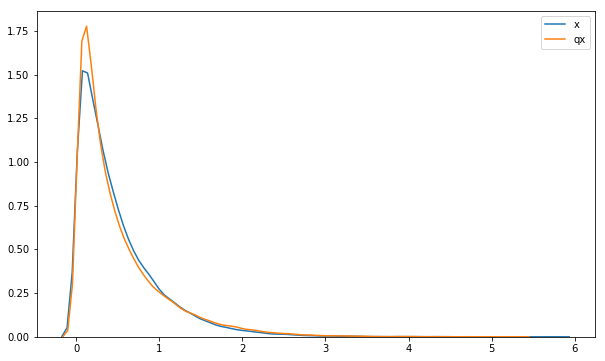

In [6]:
plt.figure(figsize=(10, 6))
sns.distplot(x.sample(50000).eval(), hist=False, label='x')
sns.distplot(qx_constrained.sample(100000).eval(), hist=False, label='qx')
plt.show()

__勾配ベースモンテカルロ__
1000サンプルとHMCアルゴリズム[`ed.HMC`](http://edwardlib.org/api/ed/HMC).を用いた実証的(Empirical)近似を考えてみると

In [7]:
qx = Empirical(params=tf.Variable(tf.random_normal([1000])))

inference = ed.HMC({x: qx})
inference.run(step_size=0.8)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 0.979


ガンマ分布と実証的(Empirical)分布のサポートは異なっており、ガンマ分布は拘束のない空間に変換されます。実装により実証的分布や点質量分布ような
離散デルタ分布(デルタ関数の和で表されるような分布)は変換されません。
`ed.HMC`はハミルトン力学系の動きをシミュレートし拘束条件のない実証的分布のサンプルを描きます。

近似をもともとの(拘束のある)サポートで行うために逆変換を再び適応しなければいけません。

In [9]:
x_unconstrained = inference.transformations[x]  # transformed prior
x_transform = x_unconstrained.bijector  # transformed prior's transformation
qx_constrained = Empirical(params=x_transform.inverse(qx.params))

変分推論とは異なり、ここでは`ed.transform`を拘束のある近似のためには用いません。これは連続的な分布にのみ適用されます。
代わりにここでは新しくパラメータ(サンプル)が拘束なしの近似の元に蓄えられたサンプルを変換したもので与えられるような実証的な分布を定義します。

以下ではこの分布の密度関数を図示します。
以下の図はサンプルがシミュレーション誤差の範囲内で正確にガンマ分布に当てはまっていることを示唆しています。

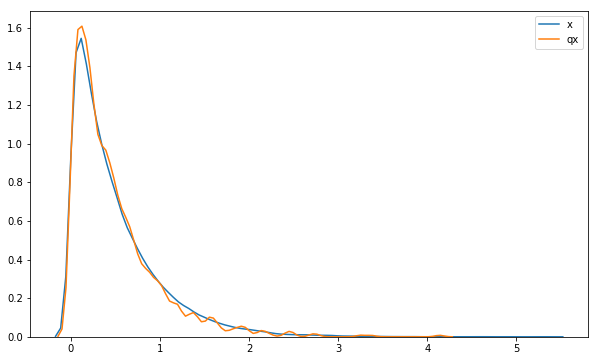

In [10]:
plt.figure(figsize=(10, 6))
sns.distplot(x.sample(50000).eval(), hist=False, label='x')
sns.distplot(qx_constrained.sample(100000).eval(), hist=False, label='qx')
plt.show()

# 謝辞と注意点

自動変換はStanにおけるハミルトンモンテカルロの手法(Carpenter et al., 2016)で有名になりました。
ここ(Edward)での設計はStanにインスパイアされましたが、Stanとの主要な違いはユーザーが
元々の(拘束された)空間と推測された(拘束のない)空間の双方で変換を
より自由に、フレキシブルに取り扱うことができるようになったことです。　

自動変換は自動微分変分推論(Kucukelbir et al., 2017)の核となる機能でもあります。
これによって正規分布族の変分のデフォルトとしてを選ぶことができるようになります。
しかしながらEdwardにおける非負の数から実数全体への自動変換はStanで使われているような$\log$ではありません。
Edwardではより数値的に安定な$\textrm{softplus}$を使っています(see also Kucukelbir et al. (2017, Fig. 9))。

最後に全ての推測アルゴリズムが自動変換を使っている、あるいは必要としている訳ではないことに注意して下さい。
[`ed.Gibbs`](http://edwardlib.org/api/ed/Gibbs)、
Edwardの共役性を使ったEPによるモーメントマッチング、
[`ed.KLqp`](http://edwardlib.org/api/ed/KLqp)のスコア関数の勾配などは全て元々の隠れた変数の空間で全ての推測処理を行います。

[`ed.MAP`](http://edwardlib.org/api/ed/MAP)のような点推定も元の隠れた変数の空間を用い、　
拘束のない自由なパラメータ拘束のある変換のみが必要になります。

[`ed.GANInference`](http://edwardlib.org/api/ed/GANInference)のようなモデルでのパラメータ推定でも隠れた変数に対して推測がなされます。
